## Overview
An on demand delivery company thrives by making customers happy.

*If they can predict what makes customers happy or unhappy, they can take the necessary actions.*

**Recent survey data subset:**  

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers  
X1 = my order was delivered on time  
X2 = contents of my order was as I expected  
X3 = I ordered everything I wanted to order  
X4 = I paid a good price for my order  
X5 = I am satisfied with my courier  
X6 = the app makes ordering easy for me  

*X values from 1 to 5 where 5 is most positive and 1 is most negative.*

**Goals:**  

*Predict (e.g., >75% accuracy) if a customer is happy or not based on the answers they give to questions asked.* 

*Identify which questions are more/less important when predicting a customer’s happiness.*  

## Imports

In [1]:
# Standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (GradientBoostingClassifier, RandomForestClassifier, 
                              ExtraTreesClassifier, VotingClassifier)
import lightgbm as lgb

# For hyperparameter tuning
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                     RandomizedSearchCV, KFold, cross_val_score)

# For evaluation
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score)
from sklearn.metrics import (roc_curve, auc)

# For quickly testing models
from pycaret.classification import (setup, compare_models)

# Statistics
from scipy.stats import yeojohnson

# Feature inspection
from sklearn.inspection import permutation_importance

C:\Users\clarkac\Anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\clarkac\Anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\clarkac\Anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


## Load data and explore

In [2]:
df = pd.read_csv('survey.csv')
print('Shape is', df.shape)
df.head(3)

Shape is (126, 7)


,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5


In [3]:
# Rename columns using info from OVERVIEW

# X1 = my order was delivered on time  
# X2 = contents of my order was as I expected  
# X3 = I ordered everything I wanted to order  
# X4 = I paid a good price for my order  
# X5 = I am satisfied with my courier  
# X6 = the app makes ordering easy for me  

old_cols = list(df.columns)
new_cols = ['customer_happiness', 'on_time', 'expected_content','order_everything', 'good_price', 
           'good_courier', 'good_app']

df.rename(columns=dict(zip(old_cols, new_cols)), inplace=True)
df.head()

,customer_happiness,on_time,expected_content,order_everything,good_price,good_courier,good_app
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [4]:
df.dtypes

customer_happiness    int64
on_time               int64
expected_content      int64
order_everything      int64
good_price            int64
good_courier          int64
good_app              int64
dtype: object

In [5]:
# Are there any nans?

df.isna().sum()

customer_happiness    0
on_time               0
expected_content      0
order_everything      0
good_price            0
good_courier          0
good_app              0
dtype: int64

In [6]:
# Are any values outside the 0-1 and 1-5 ranges?
# What are the basic statistics for each feature?

df.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_happiness,126.0,0.547619,0.499714,0.0,0.0,1.0,1.0,1.0
on_time,126.0,4.333333,0.800000,1.0,4.0,5.0,5.0,5.0
expected_content,126.0,2.531746,1.114892,1.0,2.0,3.0,3.0,5.0
order_everything,126.0,3.309524,1.023440,1.0,3.0,3.0,4.0,5.0
good_price,126.0,3.746032,0.875776,1.0,3.0,4.0,4.0,5.0
good_courier,126.0,3.650794,1.147641,1.0,3.0,4.0,4.0,5.0
good_app,126.0,4.253968,0.809311,1.0,4.0,4.0,5.0,5.0


Performance-wise (mean > 4), the company is delivering on_time and has an good_app that's easy to use. The expected contents of each order seems to be less reliable. 

In [7]:
# Group by customer happiness and check average response from each survey question

df_grouped = df.groupby('customer_happiness').agg('mean')
df_grouped

,on_time,expected_content,order_everything,good_price,good_courier,good_app
customer_happiness,,,,,,
0,4.087719,2.561404,3.140351,3.684211,3.368421,4.105263
1,4.536232,2.507246,3.449275,3.797101,3.884058,4.376812


The average rating was higher among happy customers for all features except expected_content, which barely changed. Therefore, it may be that this feature is unimportant for our predictive model.

## Visualize data distributions

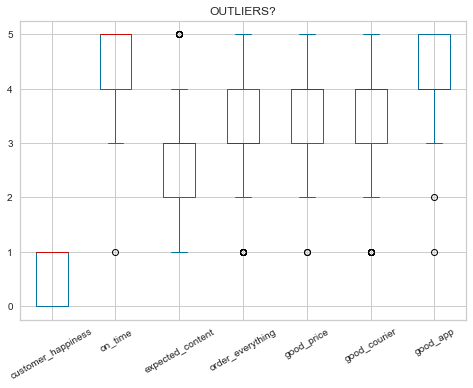

In [8]:
# Are there many outliers?

df.plot(kind='box', title='OUTLIERS?')
plt.xticks(rotation=30)
plt.show()

The primary outlier occurs for on_time. We will keep it for now.

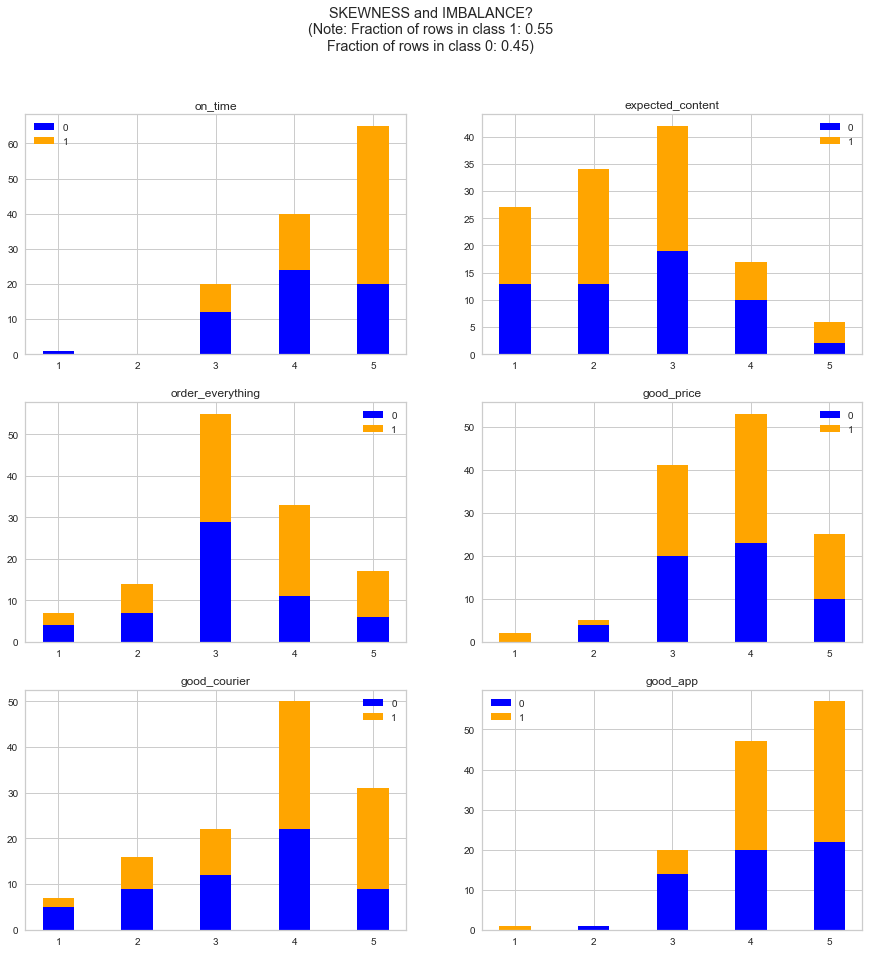

In [9]:
# Are the classes (happy = 1, unhappy = 0) balanced?
# Are the data normally distributed?

imbtitle = (f'SKEWNESS and IMBALANCE?\n(Note: Fraction of rows in class '
            f'{df.customer_happiness.value_counts(normalize=True).index[0]}: '
            f'{df.customer_happiness.value_counts(normalize=True).iloc[0]:.2}\n'
            f'Fraction of rows in class {df.customer_happiness.value_counts(normalize=True).index[1]}: '
            f'{df.customer_happiness.value_counts(normalize=True).iloc[1]:.2})')

fig, axs = plt.subplots(3, 2, figsize=(15,15))

for i in range(3):
    for j in range(2):
        df_plot = df.groupby(df.columns[(2*i+1+j)])['customer_happiness'].value_counts().unstack().fillna(0)
        
        axs[i, j].bar(df_plot.index, 
                      df_plot.iloc[:,0],
                      label=f'{df_plot.columns[0]}', 
                      width=0.4, 
                      color='blue')
        axs[i, j].bar(df_plot.index, 
                      df_plot.iloc[:,1], 
                      bottom=df_plot.iloc[:,0],
                      label=f'{df_plot.columns[1]}', 
                      width=0.4, 
                      color='orange')
        axs[i, j].set_title(df.columns[(2*i+1+j)])
        axs[i, j].legend()

        fig.suptitle(imbtitle)
plt.show()

There are more happy (55%) than unhappy (45%) customers.  

The plots align with the average ratings we viewed earlier. Deliveries are usually on_time and the good_app is easy to use. We see that ratings of 4 and 5 from these features is more often associated with the happy category (1, not 0). Although the expected_content might not be the main driver for customer_happiness, it clearly shows room for improvement.

Statistically speaking, we see that some survey results are not distributed normally: expected_content is slightly skewed right, while the others are skewed left (although order_everything is almost normal).

In [10]:
# Calculation of feature skewness

skew_vals = df.drop(columns=['customer_happiness']).skew()
skew_vals.sort_values(ascending = False)

expected_content    0.271000
order_everything   -0.199536
good_price         -0.422240
good_courier       -0.699999
good_app           -0.957590
on_time            -1.058468
dtype: float64

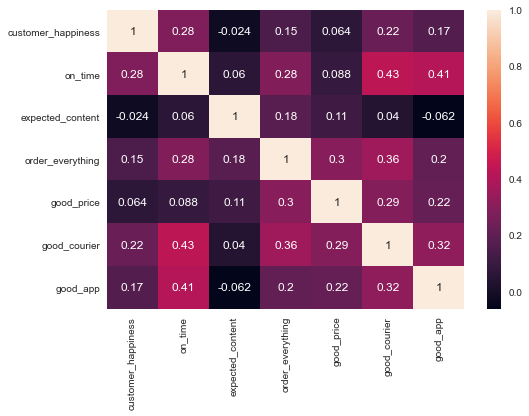

In [11]:
# Create correlation matrix

corr = df.corr()
sns.heatmap(corr, annot = True)
plt.show()

Again, we see that expected_content may not help our predictive model since it has a very low correlation with customer_happiness. Good_price also isn't strongly correlated with customer_happiness (surprisingly).

## Feature engineering

In [12]:
# Instead of battling skewness, we note that these features (survey questions)
# can be viewed as categorical, and are well suited for onehot encoding.
# This allows us to extract more information from the survey questions,
# since any particular rating might carry more weight.

df1 = pd.get_dummies(df, 
                     columns = [
                          'on_time', 
                          'expected_content', 
                          'order_everything', 
                          'good_price', 
                          'good_courier', 
                          'good_app'], 
                     drop_first = False)

df2 = pd.get_dummies(df, 
                     columns = [
                          'on_time', 
                          'order_everything', 
                          'good_price', 
                          'good_courier', 
                          'good_app'], 
                     drop_first = False)

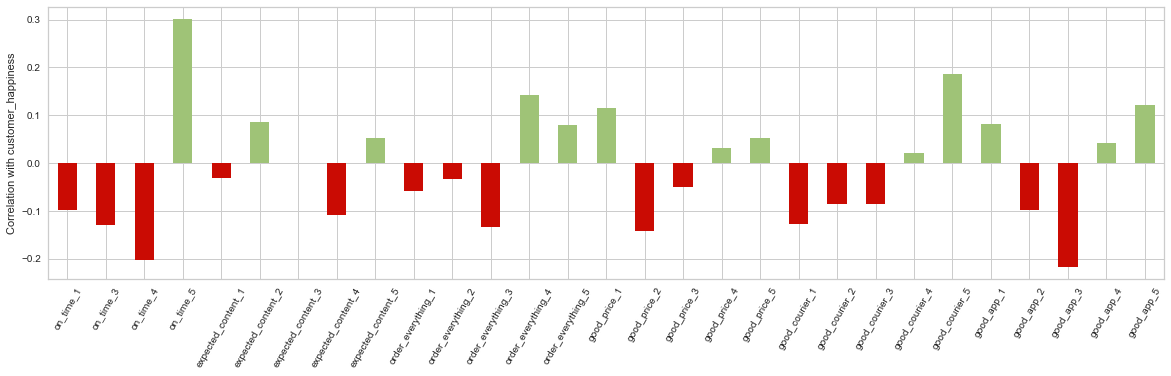

In [13]:
# Correlations for full dataset

corr = df1.corr()

# Series of interest

s = corr['customer_happiness'].drop('customer_happiness')

# Plot correlations

plt.figure(figsize=(20,5))
s.plot(kind='bar', color=(s > 0).map({True: 'g', False: 'r'}))
plt.xticks(rotation=60)
plt.xticks(np.arange(len(s)), labels=s.index)
plt.ylabel('Correlation with customer_happiness')
plt.show()

We can see that low ratings are typically associated with unhappiness, and high ratings with happiness (keeping in mind that there are a few outliers). It seems that there are a few outliers that make good_price_1 and good_app_1 go against the trend, but on the whole the features good_price (\_2 through \_5) and good_app (\_2 through \_5) are useful.  In contrast, the trend is much noisier for expected_content.

We will remove outliers and reexamine these correlations below.

reduced shape: (109, 7)


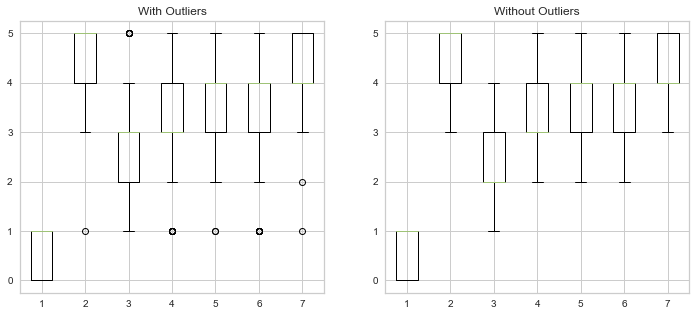

In [14]:
# Remove outliers

# Initialize dataframe
df_clean = df.copy()

# Use IQR threshold to remove all outliers one column at a time
for col in df.columns:
    
    # Ignore first column of labels
    if col != 'customer_happiness':
        
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        
        # Remove outliers
        df_clean = df_clean[(df_clean[col] >= (q1 - 1.5 * iqr)) 
                            & (df_clean[col] <= (q3 + 1.5 * iqr))]

print('reduced shape:', df_clean.shape)

# Plot comparison
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].boxplot(df)
axs[0].set_title('With Outliers')
axs[1].boxplot(df_clean)
axs[1].set_title('Without Outliers')
plt.show()

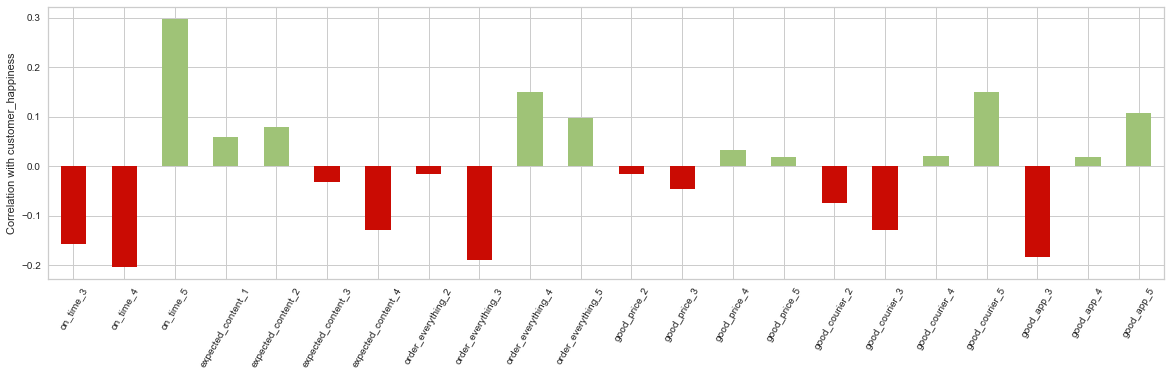

In [15]:
# Onehot, once again

df1 = pd.get_dummies(df_clean, 
                     columns = [
                          'on_time', 
                          'expected_content', 
                          'order_everything', 
                          'good_price', 
                          'good_courier', 
                          'good_app'], 
                     drop_first = False)

df2 = pd.get_dummies(df_clean, 
                     columns = [
                          'on_time', 
                          'order_everything', 
#                           'good_price', 
                          'good_courier', 
                          'good_app'], 
                     drop_first = False)

# Correlations for full dataset

corr = df1.corr()

# Series of interest

s = corr['customer_happiness'].drop('customer_happiness')

# Plot correlations

plt.figure(figsize=(20,5))
s.plot(kind='bar', color=(s > 0).map({True: 'g', False: 'r'}))
plt.xticks(rotation=60)
plt.xticks(np.arange(len(s)), labels=s.index)
plt.ylabel('Correlation with customer_happiness')
plt.show()

Now we can clearly see that low ratings are associated with unhappiness and high ratings with happiness for all survey questions but one (expected_content), for which the trend is reversed.

We will create new binary features based on thresholds for each survey question. In other words, if the survey response is above a certain threshold we return 1, and if it is below we return 0 (a step function transformation).

In [16]:
# Create new binary features based on thresholds for each survey question

# Thresholds are 4.5 for on_time, 2.4 for expected_content,
# and 3.5 for order_everything, good_price, good_courier, and good_app.
th1 = 4.5
th2 = 2.5
th3 = 3.5

# Copy dataframe
df_newfeat = df_clean.copy()

# Apply thresholding
df_newfeat['on_time_binary'] = np.where(df_newfeat['on_time'] > th1, 1, 0)
df_newfeat['expected_content_binary'] = np.where(df_newfeat['expected_content'] > th2, 1, 0)
df_newfeat['order_everything_binary'] = np.where(df_newfeat['order_everything'] > th3, 1, 0)
df_newfeat['good_price_binary'] = np.where(df_newfeat['good_price'] > th3, 1, 0)
df_newfeat['good_courier_binary'] = np.where(df_newfeat['good_courier'] > th3, 1, 0)
df_newfeat['good_app_binary'] = np.where(df_newfeat['good_app'] > th3, 1, 0)

# Drop original features
df_newfeat.drop(columns=['on_time', 'expected_content', 'order_everything', 
                         'good_price', 'good_courier', 'good_app'], 
                inplace=True)

df_newfeat.head(3)

,customer_happiness,on_time_binary,expected_content_binary,order_everything_binary,good_price_binary,good_courier_binary,good_app_binary
0,0,0,1,0,1,0,1
1,0,0,0,0,1,1,0
2,1,1,1,0,0,0,1


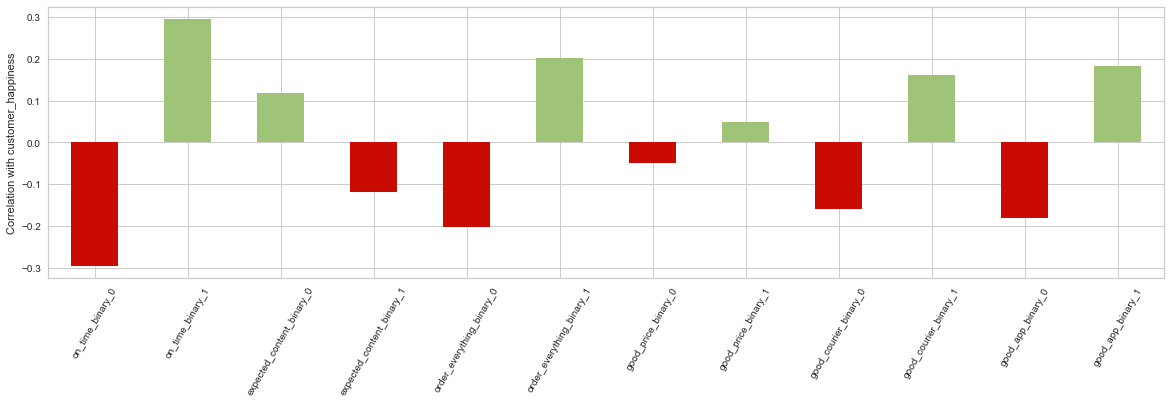

In [17]:
# Onehot, one last time

cols = df_newfeat.columns[1:]

df_last = pd.get_dummies(df_newfeat, columns=cols, drop_first=False)

# Correlations for full dataset

corr = df_last.corr()

# Series of interest

s = corr['customer_happiness'].drop('customer_happiness')

# Plot correlations

plt.figure(figsize=(20,5))
s.plot(kind='bar', color=(s > 0).map({True: 'g', False: 'r'}))
plt.xticks(rotation=60)
plt.xticks(np.arange(len(s)), labels=s.index)
plt.ylabel('Correlation with customer_happiness')
plt.show()

Based on these results, we will try modeling four different datasets:  
1. all data minus outliers, 
2. all data minus outliers, except expected_content
3. all data minus outliers, except good_price
4. all data minus outliers, except expected_content and good_price.

After some initial model exploration, we will choose 1 dataset for full model optimization.

In [18]:
df_newfeat.head()

,customer_happiness,on_time_binary,expected_content_binary,order_everything_binary,good_price_binary,good_courier_binary,good_app_binary
0,0,0,1,0,1,0,1
1,0,0,0,0,1,1,0
2,1,1,1,0,0,0,1
3,0,1,1,0,0,0,1
4,0,1,1,0,0,0,1


In [19]:
# The other 3 datasets we will use

cols = list(df_newfeat.columns[1:2]) + list(df_newfeat.columns[3:])
df_last2 = pd.get_dummies(df_newfeat
                          .drop(columns=['expected_content_binary']), 
                          columns=cols, drop_first=False)

cols = list(df_newfeat.columns[1:4]) + list(df_newfeat.columns[5:])
df_last3 = pd.get_dummies(df_newfeat
                          .drop(columns=['good_price_binary']), 
                          columns=cols, drop_first=False)

cols = list(df_newfeat.columns[1:2]) + list(df_newfeat.columns[3:4]) + list(df_newfeat.columns[5:])
df_last4 = pd.get_dummies(df_newfeat
                          .drop(columns=['expected_content_binary', 'good_price_binary']), 
                          columns=cols, drop_first=False)

In [20]:
# We are using a 70-30 train-test split for these small datasets,
# and bootstrapping the training set for modeling purposes.

y_1 = df_last['customer_happiness'].to_numpy()
X_1 = df_last.iloc[:,1:].to_numpy()
seed_val = 777
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, 
                                                        y_1, 
                                                        test_size=0.3, 
                                                        random_state=seed_val)

y_2 = df_last2['customer_happiness'].to_numpy()
X_2 = df_last2.iloc[:,1:].to_numpy()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, 
                                                        y_2, 
                                                        test_size=0.3, 
                                                        random_state=seed_val)

y_3 = df_last3['customer_happiness'].to_numpy()
X_3 = df_last3.iloc[:,1:].to_numpy()
seed_val = 777
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_3, 
                                                        y_3, 
                                                        test_size=0.3, 
                                                        random_state=seed_val)

y_4 = df_last4['customer_happiness'].to_numpy()
X_4 = df_last4.iloc[:,1:].to_numpy()
seed_val = 777
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_4, 
                                                        y_4, 
                                                        test_size=0.3, 
                                                        random_state=seed_val)

# Build 4 dataframes from training sets for PyCaret testing of models

df_train1 = pd.DataFrame(X_train1)
df_train1['Y'] = y_train1

df_train2 = pd.DataFrame(X_train2)
df_train2['Y'] = y_train2

df_train3 = pd.DataFrame(X_train3)
df_train3['Y'] = y_train3

df_train4 = pd.DataFrame(X_train4)
df_train4['Y'] = y_train4

## Data augmentation and model exploration

In [21]:
# Perform single bootstrap for each dataset

df_boot1 = df_train1.sample(n=500, replace=True, random_state=seed_val)
df_boot2 = df_train2.sample(n=500, replace=True, random_state=seed_val)
df_boot3 = df_train3.sample(n=500, replace=True, random_state=seed_val)
df_boot4 = df_train4.sample(n=500, replace=True, random_state=seed_val)

In [22]:
# Setup PyCaret and compare models for single bootstrap of full dataset

s = setup(df_boot1, target='Y', html=False, silent=True, verbose=False, data_split_stratify=True)
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7103,0.7135,0.8537,0.7238,0.7812,0.3589,0.3761,0.508


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7188,0.8183,0.7500,0.7842,0.7601,0.4185,0.4266,0.009
lr,Logistic Regression,0.7103,0.7135,0.8537,0.7238,0.7812,0.3589,0.3761,0.508


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7188,0.8183,0.7500,0.7842,0.7601,0.4185,0.4266,0.009
lr,Logistic Regression,0.7103,0.7135,0.8537,0.7238,0.7812,0.3589,0.3761,0.508
nb,Naive Bayes,0.6475,0.6895,0.7595,0.6961,0.7232,0.2397,0.2454,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7275,0.8343,0.8541,0.7430,0.7924,0.4013,0.4151,0.005
knn,K Neighbors Classifier,0.7188,0.8183,0.7500,0.7842,0.7601,0.4185,0.4266,0.009
lr,Logistic Regression,0.7103,0.7135,0.8537,0.7238,0.7812,0.3589,0.3761,0.508
nb,Naive Bayes,0.6475,0.6895,0.7595,0.6961,0.7232,0.2397,0.2454,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7275,0.8343,0.8541,0.7430,0.7924,0.4013,0.4151,0.005
knn,K Neighbors Classifier,0.7188,0.8183,0.7500,0.7842,0.7601,0.4185,0.4266,0.009
lr,Logistic Regression,0.7103,0.7135,0.8537,0.7238,0.7812,0.3589,0.3761,0.508
svm,SVM - Linear Kernel,0.6674,0.0000,0.7771,0.7140,0.7291,0.2726,0.2813,0.005
nb,Naive Bayes,0.6475,0.6895,0.7595,0.6961,0.7232,0.2397,0.2454,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7275,0.8343,0.8541,0.7430,0.7924,0.4013,0.4151,0.005
knn,K Neighbors Classifier,0.7188,0.8183,0.7500,0.7842,0.7601,0.4185,0.4266,0.009
lr,Logistic Regression,0.7103,0.7135,0.8537,0.7238,0.7812,0.3589,0.3761,0.508
ridge,Ridge Classifier,0.7074,0.0000,0.8491,0.7229,0.7787,0.3533,0.3699,0.004
svm,SVM - Linear Kernel,0.6674,0.0000,0.7771,0.7140,0.7291,0.2726,0.2813,0.005
nb,Naive Bayes,0.6475,0.6895,0.7595,0.6961,0.7232,0.2397,0.2454,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7390,0.8284,0.8827,0.7427,0.8039,0.4216,0.4486,0.077
dt,Decision Tree Classifier,0.7275,0.8343,0.8541,0.7430,0.7924,0.4013,0.4151,0.005
knn,K Neighbors Classifier,0.7188,0.8183,0.7500,0.7842,0.7601,0.4185,0.4266,0.009
lr,Logistic Regression,0.7103,0.7135,0.8537,0.7238,0.7812,0.3589,0.3761,0.508
ridge,Ridge Classifier,0.7074,0.0000,0.8491,0.7229,0.7787,0.3533,0.3699,0.004
svm,SVM - Linear Kernel,0.6674,0.0000,0.7771,0.7140,0.7291,0.2726,0.2813,0.005
nb,Naive Bayes,0.6475,0.6895,0.7595,0.6961,0.7232,0.2397,0.2454,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7390,0.8284,0.8827,0.7427,0.8039,0.4216,0.4486,0.077
dt,Decision Tree Classifier,0.7275,0.8343,0.8541,0.7430,0.7924,0.4013,0.4151,0.005
knn,K Neighbors Classifier,0.7188,0.8183,0.7500,0.7842,0.7601,0.4185,0.4266,0.009
lr,Logistic Regression,0.7103,0.7135,0.8537,0.7238,0.7812,0.3589,0.3761,0.508
ridge,Ridge Classifier,0.7074,0.0000,0.8491,0.7229,0.7787,0.3533,0.3699,0.004
qda,Quadratic Discriminant Analysis,0.6845,0.7550,0.7690,0.7359,0.7469,0.3255,0.3344,0.005
svm,SVM - Linear Kernel,0.6674,0.0000,0.7771,0.7140,0.7291,0.2726,0.2813,0.005
nb,Naive Bayes,0.6475,0.6895,0.7595,0.6961,0.7232,0.2397,0.2454,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7390,0.8284,0.8827,0.7427,0.8039,0.4216,0.4486,0.077
dt,Decision Tree Classifier,0.7275,0.8343,0.8541,0.7430,0.7924,0.4013,0.4151,0.005
knn,K Neighbors Classifier,0.7188,0.8183,0.7500,0.7842,0.7601,0.4185,0.4266,0.009
lr,Logistic Regression,0.7103,0.7135,0.8537,0.7238,0.7812,0.3589,0.3761,0.508
ada,Ada Boost Classifier,0.7103,0.7228,0.8537,0.7238,0.7812,0.3589,0.3761,0.035
ridge,Ridge Classifier,0.7074,0.0000,0.8491,0.7229,0.7787,0.3533,0.3699,0.004
qda,Quadratic Discriminant Analysis,0.6845,0.7550,0.7690,0.7359,0.7469,0.3255,0.3344,0.005
svm,SVM - Linear Kernel,0.6674,0.0000,0.7771,0.7140,0.7291,0.2726,0.2813,0.005
nb,Naive Bayes,0.6475,0.6895,0.7595,0.6961,0.7232,0.2397,0.2454,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7561,0.8342,0.9011,0.7512,0.8176,0.4581,0.4826,0.026
rf,Random Forest Classifier,0.7390,0.8284,0.8827,0.7427,0.8039,0.4216,0.4486,0.077
dt,Decision Tree Classifier,0.7275,0.8343,0.8541,0.7430,0.7924,0.4013,0.4151,0.005
knn,K Neighbors Classifier,0.7188,0.8183,0.7500,0.7842,0.7601,0.4185,0.4266,0.009
lr,Logistic Regression,0.7103,0.7135,0.8537,0.7238,0.7812,0.3589,0.3761,0.508
ada,Ada Boost Classifier,0.7103,0.7228,0.8537,0.7238,0.7812,0.3589,0.3761,0.035
ridge,Ridge Classifier,0.7074,0.0000,0.8491,0.7229,0.7787,0.3533,0.3699,0.004
qda,Quadratic Discriminant Analysis,0.6845,0.7550,0.7690,0.7359,0.7469,0.3255,0.3344,0.005
svm,SVM - Linear Kernel,0.6674,0.0000,0.7771,0.7140,0.7291,0.2726,0.2813,0.005
nb,Naive Bayes,0.6475,0.6895,0.7595,0.6961,0.7232,0.2397,0.2454,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7561,0.8342,0.9011,0.7512,0.8176,0.4581,0.4826,0.026
rf,Random Forest Classifier,0.7390,0.8284,0.8827,0.7427,0.8039,0.4216,0.4486,0.077
dt,Decision Tree Classifier,0.7275,0.8343,0.8541,0.7430,0.7924,0.4013,0.4151,0.005
knn,K Neighbors Classifier,0.7188,0.8183,0.7500,0.7842,0.7601,0.4185,0.4266,0.009
lr,Logistic Regression,0.7103,0.7135,0.8537,0.7238,0.7812,0.3589,0.3761,0.508
ada,Ada Boost Classifier,0.7103,0.7228,0.8537,0.7238,0.7812,0.3589,0.3761,0.035
ridge,Ridge Classifier,0.7074,0.0000,0.8491,0.7229,0.7787,0.3533,0.3699,0.004
lda,Linear Discriminant Analysis,0.7045,0.7141,0.8446,0.7220,0.7761,0.3479,0.3641,0.005
qda,Quadratic Discriminant Analysis,0.6845,0.7550,0.7690,0.7359,0.7469,0.3255,0.3344,0.005
svm,SVM - Linear Kernel,0.6674,0.0000,0.7771,0.7140,0.7291,0.2726,0.2813,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7561,0.8342,0.9011,0.7512,0.8176,0.4581,0.4826,0.026
rf,Random Forest Classifier,0.7390,0.8284,0.8827,0.7427,0.8039,0.4216,0.4486,0.077
dt,Decision Tree Classifier,0.7275,0.8343,0.8541,0.7430,0.7924,0.4013,0.4151,0.005
et,Extra Trees Classifier,0.7275,0.8343,0.8541,0.7430,0.7924,0.4013,0.4151,0.067
knn,K Neighbors Classifier,0.7188,0.8183,0.7500,0.7842,0.7601,0.4185,0.4266,0.009
lr,Logistic Regression,0.7103,0.7135,0.8537,0.7238,0.7812,0.3589,0.3761,0.508
ada,Ada Boost Classifier,0.7103,0.7228,0.8537,0.7238,0.7812,0.3589,0.3761,0.035
ridge,Ridge Classifier,0.7074,0.0000,0.8491,0.7229,0.7787,0.3533,0.3699,0.004
lda,Linear Discriminant Analysis,0.7045,0.7141,0.8446,0.7220,0.7761,0.3479,0.3641,0.005
qda,Quadratic Discriminant Analysis,0.6845,0.7550,0.7690,0.7359,0.7469,0.3255,0.3344,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7561,0.8342,0.9011,0.7512,0.8176,0.4581,0.4826,0.026
rf,Random Forest Classifier,0.7390,0.8284,0.8827,0.7427,0.8039,0.4216,0.4486,0.077
lightgbm,Light Gradient Boosting Machine,0.7332,0.8300,0.8636,0.7469,0.7975,0.4118,0.4332,0.116
dt,Decision Tree Classifier,0.7275,0.8343,0.8541,0.7430,0.7924,0.4013,0.4151,0.005
et,Extra Trees Classifier,0.7275,0.8343,0.8541,0.7430,0.7924,0.4013,0.4151,0.067
knn,K Neighbors Classifier,0.7188,0.8183,0.7500,0.7842,0.7601,0.4185,0.4266,0.009
lr,Logistic Regression,0.7103,0.7135,0.8537,0.7238,0.7812,0.3589,0.3761,0.508
ada,Ada Boost Classifier,0.7103,0.7228,0.8537,0.7238,0.7812,0.3589,0.3761,0.035
ridge,Ridge Classifier,0.7074,0.0000,0.8491,0.7229,0.7787,0.3533,0.3699,0.004
lda,Linear Discriminant Analysis,0.7045,0.7141,0.8446,0.7220,0.7761,0.3479,0.3641,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7561,0.8342,0.9011,0.7512,0.8176,0.4581,0.4826,0.026
rf,Random Forest Classifier,0.7390,0.8284,0.8827,0.7427,0.8039,0.4216,0.4486,0.077
lightgbm,Light Gradient Boosting Machine,0.7332,0.8300,0.8636,0.7469,0.7975,0.4118,0.4332,0.116
dt,Decision Tree Classifier,0.7275,0.8343,0.8541,0.7430,0.7924,0.4013,0.4151,0.005
et,Extra Trees Classifier,0.7275,0.8343,0.8541,0.7430,0.7924,0.4013,0.4151,0.067
knn,K Neighbors Classifier,0.7188,0.8183,0.7500,0.7842,0.7601,0.4185,0.4266,0.009
lr,Logistic Regression,0.7103,0.7135,0.8537,0.7238,0.7812,0.3589,0.3761,0.508
ada,Ada Boost Classifier,0.7103,0.7228,0.8537,0.7238,0.7812,0.3589,0.3761,0.035
ridge,Ridge Classifier,0.7074,0.0000,0.8491,0.7229,0.7787,0.3533,0.3699,0.004
lda,Linear Discriminant Analysis,0.7045,0.7141,0.8446,0.7220,0.7761,0.3479,0.3641,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7561,0.8342,0.9011,0.7512,0.8176,0.4581,0.4826,0.026
rf,Random Forest Classifier,0.7390,0.8284,0.8827,0.7427,0.8039,0.4216,0.4486,0.077
lightgbm,Light Gradient Boosting Machine,0.7332,0.8300,0.8636,0.7469,0.7975,0.4118,0.4332,0.116
dt,Decision Tree Classifier,0.7275,0.8343,0.8541,0.7430,0.7924,0.4013,0.4151,0.005
et,Extra Trees Classifier,0.7275,0.8343,0.8541,0.7430,0.7924,0.4013,0.4151,0.067
knn,K Neighbors Classifier,0.7188,0.8183,0.7500,0.7842,0.7601,0.4185,0.4266,0.009
lr,Logistic Regression,0.7103,0.7135,0.8537,0.7238,0.7812,0.3589,0.3761,0.508
ada,Ada Boost Classifier,0.7103,0.7228,0.8537,0.7238,0.7812,0.3589,0.3761,0.035
ridge,Ridge Classifier,0.7074,0.0000,0.8491,0.7229,0.7787,0.3533,0.3699,0.004
lda,Linear Discriminant Analysis,0.7045,0.7141,0.8446,0.7220,0.7761,0.3479,0.3641,0.005


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1658, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [23]:
# Setup pycaret and compare models for bootstrap minus expected_content

s = setup(df_boot2, target='Y', html=False, silent=True, verbose=False)
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6276,0.6522,0.7485,0.6736,0.7053,0.1975,0.2052,0.004


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7335,0.7885,0.8011,0.7721,0.7822,0.4378,0.4488,0.011
lr,Logistic Regression,0.6276,0.6522,0.7485,0.6736,0.7053,0.1975,0.2052,0.004


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7335,0.7885,0.8011,0.7721,0.7822,0.4378,0.4488,0.011
lr,Logistic Regression,0.6276,0.6522,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
nb,Naive Bayes,0.6162,0.6572,0.7056,0.6728,0.6833,0.1889,0.1956,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7335,0.7885,0.8011,0.7721,0.7822,0.4378,0.4488,0.011
dt,Decision Tree Classifier,0.7250,0.8136,0.8621,0.7335,0.7888,0.3975,0.4270,0.005
lr,Logistic Regression,0.6276,0.6522,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
nb,Naive Bayes,0.6162,0.6572,0.7056,0.6728,0.6833,0.1889,0.1956,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7335,0.7885,0.8011,0.7721,0.7822,0.4378,0.4488,0.011
dt,Decision Tree Classifier,0.7250,0.8136,0.8621,0.7335,0.7888,0.3975,0.4270,0.005
lr,Logistic Regression,0.6276,0.6522,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
nb,Naive Bayes,0.6162,0.6572,0.7056,0.6728,0.6833,0.1889,0.1956,0.005
svm,SVM - Linear Kernel,0.5848,0.0000,0.6970,0.5916,0.6237,0.1128,0.1324,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7335,0.7885,0.8011,0.7721,0.7822,0.4378,0.4488,0.011
dt,Decision Tree Classifier,0.7250,0.8136,0.8621,0.7335,0.7888,0.3975,0.4270,0.005
lr,Logistic Regression,0.6276,0.6522,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
ridge,Ridge Classifier,0.6276,0.0000,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
nb,Naive Bayes,0.6162,0.6572,0.7056,0.6728,0.6833,0.1889,0.1956,0.005
svm,SVM - Linear Kernel,0.5848,0.0000,0.6970,0.5916,0.6237,0.1128,0.1324,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7364,0.8126,0.8812,0.7377,0.8001,0.4190,0.4495,0.081
knn,K Neighbors Classifier,0.7335,0.7885,0.8011,0.7721,0.7822,0.4378,0.4488,0.011
dt,Decision Tree Classifier,0.7250,0.8136,0.8621,0.7335,0.7888,0.3975,0.4270,0.005
lr,Logistic Regression,0.6276,0.6522,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
ridge,Ridge Classifier,0.6276,0.0000,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
nb,Naive Bayes,0.6162,0.6572,0.7056,0.6728,0.6833,0.1889,0.1956,0.005
svm,SVM - Linear Kernel,0.5848,0.0000,0.6970,0.5916,0.6237,0.1128,0.1324,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7364,0.8126,0.8812,0.7377,0.8001,0.4190,0.4495,0.081
knn,K Neighbors Classifier,0.7335,0.7885,0.8011,0.7721,0.7822,0.4378,0.4488,0.011
dt,Decision Tree Classifier,0.7250,0.8136,0.8621,0.7335,0.7888,0.3975,0.4270,0.005
qda,Quadratic Discriminant Analysis,0.6992,0.7459,0.8009,0.7310,0.7623,0.3533,0.3604,0.005
lr,Logistic Regression,0.6276,0.6522,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
ridge,Ridge Classifier,0.6276,0.0000,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
nb,Naive Bayes,0.6162,0.6572,0.7056,0.6728,0.6833,0.1889,0.1956,0.005
svm,SVM - Linear Kernel,0.5848,0.0000,0.6970,0.5916,0.6237,0.1128,0.1324,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7364,0.8126,0.8812,0.7377,0.8001,0.4190,0.4495,0.081
knn,K Neighbors Classifier,0.7335,0.7885,0.8011,0.7721,0.7822,0.4378,0.4488,0.011
dt,Decision Tree Classifier,0.7250,0.8136,0.8621,0.7335,0.7888,0.3975,0.4270,0.005
qda,Quadratic Discriminant Analysis,0.6992,0.7459,0.8009,0.7310,0.7623,0.3533,0.3604,0.005
lr,Logistic Regression,0.6276,0.6522,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
ridge,Ridge Classifier,0.6276,0.0000,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
ada,Ada Boost Classifier,0.6276,0.6529,0.7485,0.6736,0.7053,0.1975,0.2052,0.028
nb,Naive Bayes,0.6162,0.6572,0.7056,0.6728,0.6833,0.1889,0.1956,0.005
svm,SVM - Linear Kernel,0.5848,0.0000,0.6970,0.5916,0.6237,0.1128,0.1324,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7364,0.8126,0.8812,0.7377,0.8001,0.4190,0.4495,0.081
knn,K Neighbors Classifier,0.7335,0.7885,0.8011,0.7721,0.7822,0.4378,0.4488,0.011
dt,Decision Tree Classifier,0.7250,0.8136,0.8621,0.7335,0.7888,0.3975,0.4270,0.005
gbc,Gradient Boosting Classifier,0.7221,0.8091,0.8478,0.7360,0.7851,0.3944,0.4111,0.026
qda,Quadratic Discriminant Analysis,0.6992,0.7459,0.8009,0.7310,0.7623,0.3533,0.3604,0.005
lr,Logistic Regression,0.6276,0.6522,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
ridge,Ridge Classifier,0.6276,0.0000,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
ada,Ada Boost Classifier,0.6276,0.6529,0.7485,0.6736,0.7053,0.1975,0.2052,0.028
nb,Naive Bayes,0.6162,0.6572,0.7056,0.6728,0.6833,0.1889,0.1956,0.005
svm,SVM - Linear Kernel,0.5848,0.0000,0.6970,0.5916,0.6237,0.1128,0.1324,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7364,0.8126,0.8812,0.7377,0.8001,0.4190,0.4495,0.081
knn,K Neighbors Classifier,0.7335,0.7885,0.8011,0.7721,0.7822,0.4378,0.4488,0.011
dt,Decision Tree Classifier,0.7250,0.8136,0.8621,0.7335,0.7888,0.3975,0.4270,0.005
gbc,Gradient Boosting Classifier,0.7221,0.8091,0.8478,0.7360,0.7851,0.3944,0.4111,0.026
qda,Quadratic Discriminant Analysis,0.6992,0.7459,0.8009,0.7310,0.7623,0.3533,0.3604,0.005
lr,Logistic Regression,0.6276,0.6522,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
ridge,Ridge Classifier,0.6276,0.0000,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
ada,Ada Boost Classifier,0.6276,0.6529,0.7485,0.6736,0.7053,0.1975,0.2052,0.028
lda,Linear Discriminant Analysis,0.6276,0.6430,0.7485,0.6736,0.7053,0.1975,0.2052,0.005
nb,Naive Bayes,0.6162,0.6572,0.7056,0.6728,0.6833,0.1889,0.1956,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7364,0.8126,0.8812,0.7377,0.8001,0.4190,0.4495,0.081
knn,K Neighbors Classifier,0.7335,0.7885,0.8011,0.7721,0.7822,0.4378,0.4488,0.011
dt,Decision Tree Classifier,0.7250,0.8136,0.8621,0.7335,0.7888,0.3975,0.4270,0.005
et,Extra Trees Classifier,0.7250,0.8139,0.8621,0.7335,0.7888,0.3975,0.4270,0.071
gbc,Gradient Boosting Classifier,0.7221,0.8091,0.8478,0.7360,0.7851,0.3944,0.4111,0.026
qda,Quadratic Discriminant Analysis,0.6992,0.7459,0.8009,0.7310,0.7623,0.3533,0.3604,0.005
lr,Logistic Regression,0.6276,0.6522,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
ridge,Ridge Classifier,0.6276,0.0000,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
ada,Ada Boost Classifier,0.6276,0.6529,0.7485,0.6736,0.7053,0.1975,0.2052,0.028
lda,Linear Discriminant Analysis,0.6276,0.6430,0.7485,0.6736,0.7053,0.1975,0.2052,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7364,0.8126,0.8812,0.7377,0.8001,0.4190,0.4495,0.081
knn,K Neighbors Classifier,0.7335,0.7885,0.8011,0.7721,0.7822,0.4378,0.4488,0.011
dt,Decision Tree Classifier,0.7250,0.8136,0.8621,0.7335,0.7888,0.3975,0.4270,0.005
et,Extra Trees Classifier,0.7250,0.8139,0.8621,0.7335,0.7888,0.3975,0.4270,0.071
gbc,Gradient Boosting Classifier,0.7221,0.8091,0.8478,0.7360,0.7851,0.3944,0.4111,0.026
lightgbm,Light Gradient Boosting Machine,0.7045,0.8097,0.8240,0.7264,0.7651,0.3633,0.3864,0.009
qda,Quadratic Discriminant Analysis,0.6992,0.7459,0.8009,0.7310,0.7623,0.3533,0.3604,0.005
lr,Logistic Regression,0.6276,0.6522,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
ridge,Ridge Classifier,0.6276,0.0000,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
ada,Ada Boost Classifier,0.6276,0.6529,0.7485,0.6736,0.7053,0.1975,0.2052,0.028


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7364,0.8126,0.8812,0.7377,0.8001,0.4190,0.4495,0.081
knn,K Neighbors Classifier,0.7335,0.7885,0.8011,0.7721,0.7822,0.4378,0.4488,0.011
dt,Decision Tree Classifier,0.7250,0.8136,0.8621,0.7335,0.7888,0.3975,0.4270,0.005
et,Extra Trees Classifier,0.7250,0.8139,0.8621,0.7335,0.7888,0.3975,0.4270,0.071
gbc,Gradient Boosting Classifier,0.7221,0.8091,0.8478,0.7360,0.7851,0.3944,0.4111,0.026
lightgbm,Light Gradient Boosting Machine,0.7045,0.8097,0.8240,0.7264,0.7651,0.3633,0.3864,0.009
qda,Quadratic Discriminant Analysis,0.6992,0.7459,0.8009,0.7310,0.7623,0.3533,0.3604,0.005
lr,Logistic Regression,0.6276,0.6522,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
ridge,Ridge Classifier,0.6276,0.0000,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
ada,Ada Boost Classifier,0.6276,0.6529,0.7485,0.6736,0.7053,0.1975,0.2052,0.028


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7364,0.8126,0.8812,0.7377,0.8001,0.4190,0.4495,0.081
knn,K Neighbors Classifier,0.7335,0.7885,0.8011,0.7721,0.7822,0.4378,0.4488,0.011
dt,Decision Tree Classifier,0.7250,0.8136,0.8621,0.7335,0.7888,0.3975,0.4270,0.005
et,Extra Trees Classifier,0.7250,0.8139,0.8621,0.7335,0.7888,0.3975,0.4270,0.071
gbc,Gradient Boosting Classifier,0.7221,0.8091,0.8478,0.7360,0.7851,0.3944,0.4111,0.026
lightgbm,Light Gradient Boosting Machine,0.7045,0.8097,0.8240,0.7264,0.7651,0.3633,0.3864,0.009
qda,Quadratic Discriminant Analysis,0.6992,0.7459,0.8009,0.7310,0.7623,0.3533,0.3604,0.005
lr,Logistic Regression,0.6276,0.6522,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
ridge,Ridge Classifier,0.6276,0.0000,0.7485,0.6736,0.7053,0.1975,0.2052,0.004
ada,Ada Boost Classifier,0.6276,0.6529,0.7485,0.6736,0.7053,0.1975,0.2052,0.028


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5748, verbose=0,
                       warm_start=False)


In [24]:
# Setup pycaret and compare models for bootstrap minus good_price

s = setup(df_boot3, target='Y', html=False, silent=True, verbose=False)
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7308,0.7371,0.849,0.7358,0.7868,0.4257,0.4396,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7308,0.7371,0.8490,0.7358,0.7868,0.4257,0.4396,0.005
knn,K Neighbors Classifier,0.6652,0.7271,0.7857,0.6913,0.7343,0.2851,0.2907,0.009


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7308,0.7371,0.8490,0.7358,0.7868,0.4257,0.4396,0.005
nb,Naive Bayes,0.6764,0.7234,0.7662,0.7123,0.7344,0.3198,0.3273,0.004
knn,K Neighbors Classifier,0.6652,0.7271,0.7857,0.6913,0.7343,0.2851,0.2907,0.009


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7308,0.7371,0.8490,0.7358,0.7868,0.4257,0.4396,0.005
dt,Decision Tree Classifier,0.7252,0.7742,0.8821,0.7182,0.7900,0.3997,0.4254,0.005
nb,Naive Bayes,0.6764,0.7234,0.7662,0.7123,0.7344,0.3198,0.3273,0.004
knn,K Neighbors Classifier,0.6652,0.7271,0.7857,0.6913,0.7343,0.2851,0.2907,0.009


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7308,0.7371,0.8490,0.7358,0.7868,0.4257,0.4396,0.005
dt,Decision Tree Classifier,0.7252,0.7742,0.8821,0.7182,0.7900,0.3997,0.4254,0.005
nb,Naive Bayes,0.6764,0.7234,0.7662,0.7123,0.7344,0.3198,0.3273,0.004
knn,K Neighbors Classifier,0.6652,0.7271,0.7857,0.6913,0.7343,0.2851,0.2907,0.009
svm,SVM - Linear Kernel,0.6050,0.0000,0.6383,0.6151,0.6088,0.1966,0.2150,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7337,0.0000,0.8490,0.7389,0.7886,0.4322,0.4456,0.005
lr,Logistic Regression,0.7308,0.7371,0.8490,0.7358,0.7868,0.4257,0.4396,0.005
dt,Decision Tree Classifier,0.7252,0.7742,0.8821,0.7182,0.7900,0.3997,0.4254,0.005
nb,Naive Bayes,0.6764,0.7234,0.7662,0.7123,0.7344,0.3198,0.3273,0.004
knn,K Neighbors Classifier,0.6652,0.7271,0.7857,0.6913,0.7343,0.2851,0.2907,0.009
svm,SVM - Linear Kernel,0.6050,0.0000,0.6383,0.6151,0.6088,0.1966,0.2150,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7337,0.0000,0.8490,0.7389,0.7886,0.4322,0.4456,0.005
lr,Logistic Regression,0.7308,0.7371,0.8490,0.7358,0.7868,0.4257,0.4396,0.005
dt,Decision Tree Classifier,0.7252,0.7742,0.8821,0.7182,0.7900,0.3997,0.4254,0.005
rf,Random Forest Classifier,0.7166,0.7664,0.8821,0.7098,0.7849,0.3793,0.4067,0.103
nb,Naive Bayes,0.6764,0.7234,0.7662,0.7123,0.7344,0.3198,0.3273,0.004
knn,K Neighbors Classifier,0.6652,0.7271,0.7857,0.6913,0.7343,0.2851,0.2907,0.009
svm,SVM - Linear Kernel,0.6050,0.0000,0.6383,0.6151,0.6088,0.1966,0.2150,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7337,0.0000,0.8490,0.7389,0.7886,0.4322,0.4456,0.005
lr,Logistic Regression,0.7308,0.7371,0.8490,0.7358,0.7868,0.4257,0.4396,0.005
dt,Decision Tree Classifier,0.7252,0.7742,0.8821,0.7182,0.7900,0.3997,0.4254,0.005
rf,Random Forest Classifier,0.7166,0.7664,0.8821,0.7098,0.7849,0.3793,0.4067,0.103
qda,Quadratic Discriminant Analysis,0.7136,0.7531,0.8050,0.7388,0.7673,0.3939,0.4011,0.004
nb,Naive Bayes,0.6764,0.7234,0.7662,0.7123,0.7344,0.3198,0.3273,0.004
knn,K Neighbors Classifier,0.6652,0.7271,0.7857,0.6913,0.7343,0.2851,0.2907,0.009
svm,SVM - Linear Kernel,0.6050,0.0000,0.6383,0.6151,0.6088,0.1966,0.2150,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7337,0.0000,0.8490,0.7389,0.7886,0.4322,0.4456,0.005
lr,Logistic Regression,0.7308,0.7371,0.8490,0.7358,0.7868,0.4257,0.4396,0.005
ada,Ada Boost Classifier,0.7308,0.7364,0.8490,0.7358,0.7868,0.4257,0.4396,0.030
dt,Decision Tree Classifier,0.7252,0.7742,0.8821,0.7182,0.7900,0.3997,0.4254,0.005
rf,Random Forest Classifier,0.7166,0.7664,0.8821,0.7098,0.7849,0.3793,0.4067,0.103
qda,Quadratic Discriminant Analysis,0.7136,0.7531,0.8050,0.7388,0.7673,0.3939,0.4011,0.004
nb,Naive Bayes,0.6764,0.7234,0.7662,0.7123,0.7344,0.3198,0.3273,0.004
knn,K Neighbors Classifier,0.6652,0.7271,0.7857,0.6913,0.7343,0.2851,0.2907,0.009
svm,SVM - Linear Kernel,0.6050,0.0000,0.6383,0.6151,0.6088,0.1966,0.2150,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7366,0.7772,0.8779,0.7312,0.7961,0.4293,0.4502,0.021
ridge,Ridge Classifier,0.7337,0.0000,0.8490,0.7389,0.7886,0.4322,0.4456,0.005
lr,Logistic Regression,0.7308,0.7371,0.8490,0.7358,0.7868,0.4257,0.4396,0.005
ada,Ada Boost Classifier,0.7308,0.7364,0.8490,0.7358,0.7868,0.4257,0.4396,0.030
dt,Decision Tree Classifier,0.7252,0.7742,0.8821,0.7182,0.7900,0.3997,0.4254,0.005
rf,Random Forest Classifier,0.7166,0.7664,0.8821,0.7098,0.7849,0.3793,0.4067,0.103
qda,Quadratic Discriminant Analysis,0.7136,0.7531,0.8050,0.7388,0.7673,0.3939,0.4011,0.004
nb,Naive Bayes,0.6764,0.7234,0.7662,0.7123,0.7344,0.3198,0.3273,0.004
knn,K Neighbors Classifier,0.6652,0.7271,0.7857,0.6913,0.7343,0.2851,0.2907,0.009
svm,SVM - Linear Kernel,0.6050,0.0000,0.6383,0.6151,0.6088,0.1966,0.2150,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7366,0.7772,0.8779,0.7312,0.7961,0.4293,0.4502,0.021
ridge,Ridge Classifier,0.7337,0.0000,0.8490,0.7389,0.7886,0.4322,0.4456,0.005
lda,Linear Discriminant Analysis,0.7337,0.7302,0.8490,0.7389,0.7886,0.4322,0.4456,0.004
lr,Logistic Regression,0.7308,0.7371,0.8490,0.7358,0.7868,0.4257,0.4396,0.005
ada,Ada Boost Classifier,0.7308,0.7364,0.8490,0.7358,0.7868,0.4257,0.4396,0.030
dt,Decision Tree Classifier,0.7252,0.7742,0.8821,0.7182,0.7900,0.3997,0.4254,0.005
rf,Random Forest Classifier,0.7166,0.7664,0.8821,0.7098,0.7849,0.3793,0.4067,0.103
qda,Quadratic Discriminant Analysis,0.7136,0.7531,0.8050,0.7388,0.7673,0.3939,0.4011,0.004
nb,Naive Bayes,0.6764,0.7234,0.7662,0.7123,0.7344,0.3198,0.3273,0.004
knn,K Neighbors Classifier,0.6652,0.7271,0.7857,0.6913,0.7343,0.2851,0.2907,0.009


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7366,0.7772,0.8779,0.7312,0.7961,0.4293,0.4502,0.021
ridge,Ridge Classifier,0.7337,0.0000,0.8490,0.7389,0.7886,0.4322,0.4456,0.005
lda,Linear Discriminant Analysis,0.7337,0.7302,0.8490,0.7389,0.7886,0.4322,0.4456,0.004
lr,Logistic Regression,0.7308,0.7371,0.8490,0.7358,0.7868,0.4257,0.4396,0.005
ada,Ada Boost Classifier,0.7308,0.7364,0.8490,0.7358,0.7868,0.4257,0.4396,0.030
dt,Decision Tree Classifier,0.7252,0.7742,0.8821,0.7182,0.7900,0.3997,0.4254,0.005
et,Extra Trees Classifier,0.7252,0.7742,0.8821,0.7182,0.7900,0.3997,0.4254,0.065
rf,Random Forest Classifier,0.7166,0.7664,0.8821,0.7098,0.7849,0.3793,0.4067,0.103
qda,Quadratic Discriminant Analysis,0.7136,0.7531,0.8050,0.7388,0.7673,0.3939,0.4011,0.004
nb,Naive Bayes,0.6764,0.7234,0.7662,0.7123,0.7344,0.3198,0.3273,0.004


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7366,0.7772,0.8779,0.7312,0.7961,0.4293,0.4502,0.021
ridge,Ridge Classifier,0.7337,0.0000,0.8490,0.7389,0.7886,0.4322,0.4456,0.005
lda,Linear Discriminant Analysis,0.7337,0.7302,0.8490,0.7389,0.7886,0.4322,0.4456,0.004
lr,Logistic Regression,0.7308,0.7371,0.8490,0.7358,0.7868,0.4257,0.4396,0.005
ada,Ada Boost Classifier,0.7308,0.7364,0.8490,0.7358,0.7868,0.4257,0.4396,0.030
dt,Decision Tree Classifier,0.7252,0.7742,0.8821,0.7182,0.7900,0.3997,0.4254,0.005
et,Extra Trees Classifier,0.7252,0.7742,0.8821,0.7182,0.7900,0.3997,0.4254,0.065
lightgbm,Light Gradient Boosting Machine,0.7222,0.7669,0.8533,0.7256,0.7819,0.4020,0.4202,0.009
rf,Random Forest Classifier,0.7166,0.7664,0.8821,0.7098,0.7849,0.3793,0.4067,0.103
qda,Quadratic Discriminant Analysis,0.7136,0.7531,0.8050,0.7388,0.7673,0.3939,0.4011,0.004


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7366,0.7772,0.8779,0.7312,0.7961,0.4293,0.4502,0.021
ridge,Ridge Classifier,0.7337,0.0000,0.8490,0.7389,0.7886,0.4322,0.4456,0.005
lda,Linear Discriminant Analysis,0.7337,0.7302,0.8490,0.7389,0.7886,0.4322,0.4456,0.004
lr,Logistic Regression,0.7308,0.7371,0.8490,0.7358,0.7868,0.4257,0.4396,0.005
ada,Ada Boost Classifier,0.7308,0.7364,0.8490,0.7358,0.7868,0.4257,0.4396,0.030
dt,Decision Tree Classifier,0.7252,0.7742,0.8821,0.7182,0.7900,0.3997,0.4254,0.005
et,Extra Trees Classifier,0.7252,0.7742,0.8821,0.7182,0.7900,0.3997,0.4254,0.065
lightgbm,Light Gradient Boosting Machine,0.7222,0.7669,0.8533,0.7256,0.7819,0.4020,0.4202,0.009
rf,Random Forest Classifier,0.7166,0.7664,0.8821,0.7098,0.7849,0.3793,0.4067,0.103
qda,Quadratic Discriminant Analysis,0.7136,0.7531,0.8050,0.7388,0.7673,0.3939,0.4011,0.004


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7366,0.7772,0.8779,0.7312,0.7961,0.4293,0.4502,0.021
ridge,Ridge Classifier,0.7337,0.0000,0.8490,0.7389,0.7886,0.4322,0.4456,0.005
lda,Linear Discriminant Analysis,0.7337,0.7302,0.8490,0.7389,0.7886,0.4322,0.4456,0.004
lr,Logistic Regression,0.7308,0.7371,0.8490,0.7358,0.7868,0.4257,0.4396,0.005
ada,Ada Boost Classifier,0.7308,0.7364,0.8490,0.7358,0.7868,0.4257,0.4396,0.030
dt,Decision Tree Classifier,0.7252,0.7742,0.8821,0.7182,0.7900,0.3997,0.4254,0.005
et,Extra Trees Classifier,0.7252,0.7742,0.8821,0.7182,0.7900,0.3997,0.4254,0.065
lightgbm,Light Gradient Boosting Machine,0.7222,0.7669,0.8533,0.7256,0.7819,0.4020,0.4202,0.009
rf,Random Forest Classifier,0.7166,0.7664,0.8821,0.7098,0.7849,0.3793,0.4067,0.103
qda,Quadratic Discriminant Analysis,0.7136,0.7531,0.8050,0.7388,0.7673,0.3939,0.4011,0.004


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=6549, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [25]:
# Setup pycaret and compare models for bootstrap minus expected_content and good_price

s = setup(df_boot4, target='Y', html=False, silent=True, verbose=False)
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6388,0.6971,0.79,0.6776,0.7279,0.1987,0.2069,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6934,0.7206,0.7041,0.7838,0.7334,0.3672,0.3794,0.015
lr,Logistic Regression,0.6388,0.6971,0.7900,0.6776,0.7279,0.1987,0.2069,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6934,0.7206,0.7041,0.7838,0.7334,0.3672,0.3794,0.015
lr,Logistic Regression,0.6388,0.6971,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
nb,Naive Bayes,0.6073,0.6667,0.7149,0.6711,0.6896,0.1537,0.1564,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6934,0.7206,0.7041,0.7838,0.7334,0.3672,0.3794,0.015
dt,Decision Tree Classifier,0.6818,0.7481,0.7277,0.7464,0.7325,0.3347,0.3409,0.009
lr,Logistic Regression,0.6388,0.6971,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
nb,Naive Bayes,0.6073,0.6667,0.7149,0.6711,0.6896,0.1537,0.1564,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6934,0.7206,0.7041,0.7838,0.7334,0.3672,0.3794,0.015
dt,Decision Tree Classifier,0.6818,0.7481,0.7277,0.7464,0.7325,0.3347,0.3409,0.009
lr,Logistic Regression,0.6388,0.6971,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
nb,Naive Bayes,0.6073,0.6667,0.7149,0.6711,0.6896,0.1537,0.1564,0.005
svm,SVM - Linear Kernel,0.5961,0.0000,0.7861,0.6771,0.6968,0.0761,0.0896,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6934,0.7206,0.7041,0.7838,0.7334,0.3672,0.3794,0.015
dt,Decision Tree Classifier,0.6818,0.7481,0.7277,0.7464,0.7325,0.3347,0.3409,0.009
lr,Logistic Regression,0.6388,0.6971,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
ridge,Ridge Classifier,0.6388,0.0000,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
nb,Naive Bayes,0.6073,0.6667,0.7149,0.6711,0.6896,0.1537,0.1564,0.005
svm,SVM - Linear Kernel,0.5961,0.0000,0.7861,0.6771,0.6968,0.0761,0.0896,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6934,0.7206,0.7041,0.7838,0.7334,0.3672,0.3794,0.015
dt,Decision Tree Classifier,0.6818,0.7481,0.7277,0.7464,0.7325,0.3347,0.3409,0.009
rf,Random Forest Classifier,0.6675,0.7457,0.7558,0.7155,0.7306,0.2909,0.3001,0.078
lr,Logistic Regression,0.6388,0.6971,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
ridge,Ridge Classifier,0.6388,0.0000,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
nb,Naive Bayes,0.6073,0.6667,0.7149,0.6711,0.6896,0.1537,0.1564,0.005
svm,SVM - Linear Kernel,0.5961,0.0000,0.7861,0.6771,0.6968,0.0761,0.0896,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6934,0.7206,0.7041,0.7838,0.7334,0.3672,0.3794,0.015
dt,Decision Tree Classifier,0.6818,0.7481,0.7277,0.7464,0.7325,0.3347,0.3409,0.009
rf,Random Forest Classifier,0.6675,0.7457,0.7558,0.7155,0.7306,0.2909,0.3001,0.078
lr,Logistic Regression,0.6388,0.6971,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
ridge,Ridge Classifier,0.6388,0.0000,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
qda,Quadratic Discriminant Analysis,0.6331,0.6818,0.6916,0.7101,0.6930,0.2299,0.2388,0.004
nb,Naive Bayes,0.6073,0.6667,0.7149,0.6711,0.6896,0.1537,0.1564,0.005
svm,SVM - Linear Kernel,0.5961,0.0000,0.7861,0.6771,0.6968,0.0761,0.0896,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6934,0.7206,0.7041,0.7838,0.7334,0.3672,0.3794,0.015
dt,Decision Tree Classifier,0.6818,0.7481,0.7277,0.7464,0.7325,0.3347,0.3409,0.009
rf,Random Forest Classifier,0.6675,0.7457,0.7558,0.7155,0.7306,0.2909,0.3001,0.078
lr,Logistic Regression,0.6388,0.6971,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
ridge,Ridge Classifier,0.6388,0.0000,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
qda,Quadratic Discriminant Analysis,0.6331,0.6818,0.6916,0.7101,0.6930,0.2299,0.2388,0.004
ada,Ada Boost Classifier,0.6331,0.6978,0.7900,0.6725,0.7247,0.1841,0.1927,0.041
nb,Naive Bayes,0.6073,0.6667,0.7149,0.6711,0.6896,0.1537,0.1564,0.005
svm,SVM - Linear Kernel,0.5961,0.0000,0.7861,0.6771,0.6968,0.0761,0.0896,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6934,0.7206,0.7041,0.7838,0.7334,0.3672,0.3794,0.015
dt,Decision Tree Classifier,0.6818,0.7481,0.7277,0.7464,0.7325,0.3347,0.3409,0.009
gbc,Gradient Boosting Classifier,0.6818,0.7452,0.7604,0.7288,0.7392,0.3243,0.3335,0.045
rf,Random Forest Classifier,0.6675,0.7457,0.7558,0.7155,0.7306,0.2909,0.3001,0.078
lr,Logistic Regression,0.6388,0.6971,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
ridge,Ridge Classifier,0.6388,0.0000,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
qda,Quadratic Discriminant Analysis,0.6331,0.6818,0.6916,0.7101,0.6930,0.2299,0.2388,0.004
ada,Ada Boost Classifier,0.6331,0.6978,0.7900,0.6725,0.7247,0.1841,0.1927,0.041
nb,Naive Bayes,0.6073,0.6667,0.7149,0.6711,0.6896,0.1537,0.1564,0.005
svm,SVM - Linear Kernel,0.5961,0.0000,0.7861,0.6771,0.6968,0.0761,0.0896,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6934,0.7206,0.7041,0.7838,0.7334,0.3672,0.3794,0.015
dt,Decision Tree Classifier,0.6818,0.7481,0.7277,0.7464,0.7325,0.3347,0.3409,0.009
gbc,Gradient Boosting Classifier,0.6818,0.7452,0.7604,0.7288,0.7392,0.3243,0.3335,0.045
rf,Random Forest Classifier,0.6675,0.7457,0.7558,0.7155,0.7306,0.2909,0.3001,0.078
lr,Logistic Regression,0.6388,0.6971,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
ridge,Ridge Classifier,0.6388,0.0000,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
lda,Linear Discriminant Analysis,0.6388,0.7047,0.7900,0.6776,0.7279,0.1987,0.2069,0.017
qda,Quadratic Discriminant Analysis,0.6331,0.6818,0.6916,0.7101,0.6930,0.2299,0.2388,0.004
ada,Ada Boost Classifier,0.6331,0.6978,0.7900,0.6725,0.7247,0.1841,0.1927,0.041
nb,Naive Bayes,0.6073,0.6667,0.7149,0.6711,0.6896,0.1537,0.1564,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6934,0.7206,0.7041,0.7838,0.7334,0.3672,0.3794,0.015
dt,Decision Tree Classifier,0.6818,0.7481,0.7277,0.7464,0.7325,0.3347,0.3409,0.009
gbc,Gradient Boosting Classifier,0.6818,0.7452,0.7604,0.7288,0.7392,0.3243,0.3335,0.045
et,Extra Trees Classifier,0.6818,0.7481,0.7277,0.7464,0.7325,0.3347,0.3409,0.243
rf,Random Forest Classifier,0.6675,0.7457,0.7558,0.7155,0.7306,0.2909,0.3001,0.078
lr,Logistic Regression,0.6388,0.6971,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
ridge,Ridge Classifier,0.6388,0.0000,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
lda,Linear Discriminant Analysis,0.6388,0.7047,0.7900,0.6776,0.7279,0.1987,0.2069,0.017
qda,Quadratic Discriminant Analysis,0.6331,0.6818,0.6916,0.7101,0.6930,0.2299,0.2388,0.004
ada,Ada Boost Classifier,0.6331,0.6978,0.7900,0.6725,0.7247,0.1841,0.1927,0.041


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6934,0.7206,0.7041,0.7838,0.7334,0.3672,0.3794,0.015
lightgbm,Light Gradient Boosting Machine,0.6845,0.7298,0.7838,0.7238,0.7496,0.3189,0.3265,0.021
dt,Decision Tree Classifier,0.6818,0.7481,0.7277,0.7464,0.7325,0.3347,0.3409,0.009
gbc,Gradient Boosting Classifier,0.6818,0.7452,0.7604,0.7288,0.7392,0.3243,0.3335,0.045
et,Extra Trees Classifier,0.6818,0.7481,0.7277,0.7464,0.7325,0.3347,0.3409,0.243
rf,Random Forest Classifier,0.6675,0.7457,0.7558,0.7155,0.7306,0.2909,0.3001,0.078
lr,Logistic Regression,0.6388,0.6971,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
ridge,Ridge Classifier,0.6388,0.0000,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
lda,Linear Discriminant Analysis,0.6388,0.7047,0.7900,0.6776,0.7279,0.1987,0.2069,0.017
qda,Quadratic Discriminant Analysis,0.6331,0.6818,0.6916,0.7101,0.6930,0.2299,0.2388,0.004


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6934,0.7206,0.7041,0.7838,0.7334,0.3672,0.3794,0.015
lightgbm,Light Gradient Boosting Machine,0.6845,0.7298,0.7838,0.7238,0.7496,0.3189,0.3265,0.021
dt,Decision Tree Classifier,0.6818,0.7481,0.7277,0.7464,0.7325,0.3347,0.3409,0.009
gbc,Gradient Boosting Classifier,0.6818,0.7452,0.7604,0.7288,0.7392,0.3243,0.3335,0.045
et,Extra Trees Classifier,0.6818,0.7481,0.7277,0.7464,0.7325,0.3347,0.3409,0.243
rf,Random Forest Classifier,0.6675,0.7457,0.7558,0.7155,0.7306,0.2909,0.3001,0.078
lr,Logistic Regression,0.6388,0.6971,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
ridge,Ridge Classifier,0.6388,0.0000,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
lda,Linear Discriminant Analysis,0.6388,0.7047,0.7900,0.6776,0.7279,0.1987,0.2069,0.017
qda,Quadratic Discriminant Analysis,0.6331,0.6818,0.6916,0.7101,0.6930,0.2299,0.2388,0.004


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6934,0.7206,0.7041,0.7838,0.7334,0.3672,0.3794,0.015
lightgbm,Light Gradient Boosting Machine,0.6845,0.7298,0.7838,0.7238,0.7496,0.3189,0.3265,0.021
dt,Decision Tree Classifier,0.6818,0.7481,0.7277,0.7464,0.7325,0.3347,0.3409,0.009
gbc,Gradient Boosting Classifier,0.6818,0.7452,0.7604,0.7288,0.7392,0.3243,0.3335,0.045
et,Extra Trees Classifier,0.6818,0.7481,0.7277,0.7464,0.7325,0.3347,0.3409,0.243
rf,Random Forest Classifier,0.6675,0.7457,0.7558,0.7155,0.7306,0.2909,0.3001,0.078
lr,Logistic Regression,0.6388,0.6971,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
ridge,Ridge Classifier,0.6388,0.0000,0.7900,0.6776,0.7279,0.1987,0.2069,0.005
lda,Linear Discriminant Analysis,0.6388,0.7047,0.7900,0.6776,0.7279,0.1987,0.2069,0.017
qda,Quadratic Discriminant Analysis,0.6331,0.6818,0.6916,0.7101,0.6930,0.2299,0.2388,0.004


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


The tree-based models performed best, and they do so on the full dataset. For the full dataset, we will optimize the Decision Tree, Random Forest, Gradient Boosting, Light GBM, and Extra Trees classifiers. Also, we can try K Nieghbors, since it is so quick and easy to tune. We will also use the Voting Classifier, if suitable.

## Modeling

In [26]:
# Rename training and test datasets
Xboot = df_boot1.iloc[:,:-1].to_numpy()
yboot = df_boot1.iloc[:,-1].to_numpy()
Xt = X_test1
yt = y_test1

#### Decision Tree

In [27]:
# Instantiate

dtc = DecisionTreeClassifier()

# Define parameter grid

dtc_par_grid = {'max_features': np.arange(2, 20), 
                'min_samples_split': np.arange(2, 20),
                'max_depth': np.arange(2, 20)
               }

# Define grid - use random search since the grid is large (faster than GridSearch)

dtc_grid = RandomizedSearchCV(estimator=dtc,  
                              param_distributions=dtc_par_grid, 
                              cv = 3, 
                              refit=True, 
                              verbose=2, 
                              n_jobs=-1, 
                              n_iter=1000,
                              random_state=seed_val)

# Fitting

dtc_grid.fit(Xboot, yboot)
print(f'Best parameters are {dtc_grid.best_params_}\n')
print(f'Best score is {dtc_grid.best_score_}\n')

# Predict

dtc_grid_pred = dtc_grid.predict(Xt)

# Classification report

print(classification_report(yt, dtc_grid_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(yt, 
                               dtc_grid_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:    3.3s


Best parameters are {'min_samples_split': 3, 'max_features': 9, 'max_depth': 5}

Best score is 0.7639900921049468

              precision    recall  f1-score   support

           0       0.78      0.44      0.56        16
           1       0.62      0.88      0.73        17

    accuracy                           0.67        33
   macro avg       0.70      0.66      0.65        33
weighted avg       0.70      0.67      0.65        33



[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    4.6s finished


Predicted,0,1
Actual,,
0,7,9
1,2,15


#### Random Forest

In [50]:
# Instantiate

rfc = RandomForestClassifier()

# Define parameter grid

rfc_par_grid = {'n_estimators': [100, 1000],
               'max_depth': [3, 5, 8, 15, 30, None],
               'min_samples_split': [2, 4, 6, 10]}

# Define grid

rfc_grid = RandomizedSearchCV(estimator=rfc,  
                              param_distributions=rfc_par_grid, 
                              cv = 3, 
                              refit=True, 
                              verbose=2, 
                              n_jobs=-1, 
                              n_iter=400, 
                              random_state=seed_val)

# Fitting full dataset

rfc_grid.fit(Xboot, yboot)
print(f'Best parameters are {rfc_grid.best_params_}\n')
print(f'Best score is {rfc_grid.best_score_}\n')

# Predict

rfc_grid_pred = rfc_grid.predict(Xt)

# Classification report

print(classification_report(yt, rfc_grid_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(yt, 
                               rfc_grid_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   38.7s finished


Best parameters are {'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 8}

Best score is 0.7559579635908905

              precision    recall  f1-score   support

           0       0.91      0.62      0.74        16
           1       0.73      0.94      0.82        17

    accuracy                           0.79        33
   macro avg       0.82      0.78      0.78        33
weighted avg       0.82      0.79      0.78        33



Predicted,0,1
Actual,,
0,10,6
1,1,16


#### Extra Trees

In [51]:
# Instantiate

etc = ExtraTreesClassifier()

# Define parameter grid

etc_par_grid = {'n_estimators': [100, 1000],
               'max_depth': [3, 5, 8, 15, 30, None],
               'min_samples_split': [2, 4, 6, 10]}

# Define grid - use random search since the grid is large (faster than GridSearch)

etc_grid = RandomizedSearchCV(estimator=etc,  
                              param_distributions=etc_par_grid, 
                              cv = 3, 
                              refit=True, 
                              verbose=2, 
                              n_jobs=-1, 
                              n_iter=200,
                              random_state=seed_val)

# Fitting

etc_grid.fit(Xboot, yboot)
print(f'Best parameters are {etc_grid.best_params_}\n')
print(f'Best score is {etc_grid.best_score_}\n')

# Predict

etc_grid_pred = etc_grid.predict(Xt)

# Classification report

print(classification_report(yt, etc_grid_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(yt, 
                               etc_grid_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s


Best parameters are {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 8}

Best score is 0.747997979943727

              precision    recall  f1-score   support

           0       0.82      0.56      0.67        16
           1       0.68      0.88      0.77        17

    accuracy                           0.73        33
   macro avg       0.75      0.72      0.72        33
weighted avg       0.75      0.73      0.72        33



[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   26.3s finished


Predicted,0,1
Actual,,
0,9,7
1,2,15


#### Light GBM

In [30]:
# Instantiate

lgbm = lgb.LGBMClassifier()

# Define parameter grid

lgbm_par_grid = {'num_leaves': [5, 15, 30, 50, 100], 
                 'min_child_samples': [5, 10, 20, 40], 
                 'max_depth': [-1, 5, 10, 20], 
                 'learning_rate': [0.01, 0.05, 0.1, 0.2], 
                 'reg_alpha': [0, 0.01, 0.03]}

# Define grid - use random search since the grid is large (faster than GridSearch)

lgbm_grid = RandomizedSearchCV(estimator=lgbm,  
                              param_distributions=lgbm_par_grid, 
                              cv = 3, 
                              refit=True, 
                              verbose=2, 
                              n_jobs=-1, 
                              n_iter=1000, 
                              random_state=seed_val)

# Fitting full dataset

lgbm_grid.fit(Xboot, yboot)
print(f'Best parameters are {lgbm_grid.best_params_}\n')
print(f'Best score is {lgbm_grid.best_score_}\n')

# Predict

lgbm_grid_pred = lgbm_grid.predict(Xt)

# Classification report

print(classification_report(yt, lgbm_grid_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(yt, 
                               lgbm_grid_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:   19.6s finished


Best parameters are {'reg_alpha': 0.01, 'num_leaves': 30, 'min_child_samples': 5, 'max_depth': 5, 'learning_rate': 0.2}

Best score is 0.7559579635908905

              precision    recall  f1-score   support

           0       0.82      0.56      0.67        16
           1       0.68      0.88      0.77        17

    accuracy                           0.73        33
   macro avg       0.75      0.72      0.72        33
weighted avg       0.75      0.73      0.72        33



Predicted,0,1
Actual,,
0,9,7
1,2,15


#### Gradient Boosting

In [31]:
# Instantiate

gbc = GradientBoostingClassifier()

# Define parameter grid

gbc_par_grid = {'max_features': [2, 3, 4, 5], 
                'min_samples_split': [2, 4, 6, 10], 
                'max_depth': [2, 3, 5, 10, 20], 
                'subsample': [1.0, 0.8], 
                'n_estimators': [100, 500], 
                'learning_rate': [0.05, 0.1, 0.2]
               }

# Define grid - use random search since the grid is large (faster than GridSearch)

gbc_grid = RandomizedSearchCV(estimator=gbc,  
                              param_distributions=gbc_par_grid, 
                              cv = 3, 
                              refit=True, 
                              verbose=2, 
                              n_jobs=-1, 
                              n_iter=400,
                              random_state=seed_val)

# Fitting

gbc_grid.fit(Xboot, yboot)
print(f'Best parameters are {gbc_grid.best_params_}\n')
print(f'Best score is {gbc_grid.best_score_}\n')

# Predict

gbc_grid_pred = gbc_grid.predict(Xt)

# Classification report

print(classification_report(yt, gbc_grid_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(yt, 
                               gbc_grid_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])

confusion_matrix

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.6min finished


Best parameters are {'subsample': 0.8, 'n_estimators': 500, 'min_samples_split': 10, 'max_features': 2, 'max_depth': 3, 'learning_rate': 0.05}

Best score is 0.7599740278479187

              precision    recall  f1-score   support

           0       0.89      0.50      0.64        16
           1       0.67      0.94      0.78        17

    accuracy                           0.73        33
   macro avg       0.78      0.72      0.71        33
weighted avg       0.77      0.73      0.71        33



Predicted,0,1
Actual,,
0,8,8
1,1,16


#### K Neighbors

In [32]:
# Instantiate

knn = KNeighborsClassifier()

# Define parameter grid

knn_par_grid = {'n_neighbors': np.arange(1,20),  
                'weights': ['uniform', 'distance']}

# Define grid

knn_grid = GridSearchCV(estimator=knn, 
                        param_grid=knn_par_grid, 
                        cv = 3, 
                        refit=True, 
                        verbose=2,
                        n_jobs=-1)

# Fitting full dataset

knn_grid.fit(Xboot, yboot)
print(f'Best parameters are {knn_grid.best_params_}\n')
print(f'Best score is {knn_grid.best_score_}\n')

# Predict

knn_grid_pred = knn_grid.predict(Xt)

# Classification report

print(classification_report(yt, knn_grid_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(yt, 
                               knn_grid_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

Fitting 3 folds for each of 38 candidates, totalling 114 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s


Best parameters are {'n_neighbors': 19, 'weights': 'distance'}

Best score is 0.7559820118798548

              precision    recall  f1-score   support

           0       0.75      0.56      0.64        16
           1       0.67      0.82      0.74        17

    accuracy                           0.70        33
   macro avg       0.71      0.69      0.69        33
weighted avg       0.71      0.70      0.69        33



[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    0.3s finished


Predicted,0,1
Actual,,
0,9,7
1,3,14


Random Forest performed the best, with Extra Trees and Light GBM next in line in terms of f1-scores.

### Voting Classifier

In [52]:
# Combine Random Forest, Extra Trees, and LightGBM classifiers evenly ('hard' voting)

# Instantiate with best parameters

rfc = RandomForestClassifier(n_estimators=1000, 
                            min_samples_split=2, 
                            max_depth=8)

etc = ExtraTreesClassifier(n_estimators=100, 
                           min_samples_split=2,  
                           max_depth=8)

lgbm = lgb.LGBMClassifier(reg_alpha=0.01, 
                          num_leaves=30, 
                          min_child_samples=5, 
                          max_depth=5, 
                          learning_rate=0.2)

# Create the Voting Classifier with hard voting

vclf = VotingClassifier(estimators=[('est1', rfc), 
                                    ('est2', etc), 
                                    ('est3', lgbm)], 
                        voting = 'hard')

#Fit and predict

vclf.fit(Xboot, yboot)
vclf_pred = vclf.predict(Xt)

# Classification report

print(classification_report(yt, vclf_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(yt, 
                               vclf_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

              precision    recall  f1-score   support

           0       0.83      0.62      0.71        16
           1       0.71      0.88      0.79        17

    accuracy                           0.76        33
   macro avg       0.77      0.75      0.75        33
weighted avg       0.77      0.76      0.75        33



Predicted,0,1
Actual,,
0,10,6
1,2,15


Random Forest is better than the hard Voting Classifier, so let's see if adjusting the weights will help.

In [59]:
# Due to a very small dataset, we couldn't set aside a validation set,
# thus we will use the test set when optimizing the Voting Classifier 
# (nonideal, but let's see what happens)

# Try adjusting weights of the Voting Classifier

# Weights
w1 = []
w2 = []
w3 = []
scores = []

# Loop over different combinations of weights

for i in np.arange(0, 1.1, 0.1):
    for j in np.arange(0, 1.1, 0.1):
        for k in np.arange(0, 1.1, 0.1):
            
            # Desirable condition for weights
            if i + j + k == 1:

                vclf = VotingClassifier(estimators=[('est1', rfc), 
                                                    ('est2', etc), 
                                                    ('est3', lgbm)], 
                                        voting='soft', 
                                        weights=[i, j, k])

                vclf.fit(Xboot, yboot)
                pred = vclf.predict(Xt)
                score = accuracy_score(yt, pred)
                scores.append(score)
                w1.append(i)
                w2.append(j)
                w3.append(k)

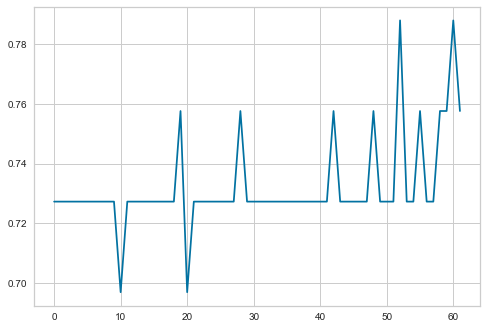

In [60]:
plt.plot(scores)
plt.show()

In [61]:
print(f'Highest scores of {np.max(scores):.3} occurr at indices: '
      f'{np.argwhere(scores == np.max(scores)).flatten().tolist()}.')

Highest scores of 0.788 occurr at indices: [52, 60].


In [62]:
# Put values into dataframe to look at optimal weights for classifiers
                                                               
df_scores = pd.DataFrame()
df_scores['scores'] = scores
df_scores['rfc'] = w1
df_scores['etc'] = w2
df_scores['lgbm'] = w3

# Best scores

how_many = len(np.argwhere(scores == np.max(scores)).flatten().tolist())
best_score = df_scores.sort_values(by=['scores'], ascending=False).head(how_many)
best_score

,scores,rfc,etc,lgbm
60,0.787879,0.9,0.1,0.0
52,0.787879,0.6,0.4,0.0


In [63]:
for c in best_score.columns[1:]:
    print('Count for',c,f'is {best_score[best_score[c] > 0][c].count()}')

Count for rfc is 2
Count for etc is 2
Count for lgbm is 0


From the weights we see that the Light GBM is always neglected.   
Of the two options, it turns out both perform the same as the Random Forest itself. Therefore, we will simplify and keep the Random Forest as the classifier model for this problem.

In [68]:
# Permutation test to determine and record feature importances

rfc.fit(Xboot, yboot)

r = permutation_importance(rfc, Xt, yt, n_repeats=30, random_state=9)

# Dictionary for features and importances
feat = {}  

# Carry out the permutation
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        feat[df_last.iloc[:,1:].columns[i]] = [r.importances_mean[i], r.importances_std[i]]

# Print results
for k, v in feat.items():     
    print(f'{k:<30}'
          f'mean: {v[0]:.3f}'
          f' +/- {v[1]:.3f}')

order_everything_binary_1     mean: 0.120 +/- 0.048
order_everything_binary_0     mean: 0.120 +/- 0.048
good_courier_binary_0         mean: 0.087 +/- 0.028
good_courier_binary_1         mean: 0.082 +/- 0.026
on_time_binary_1              mean: 0.078 +/- 0.035
on_time_binary_0              mean: 0.078 +/- 0.035


## Conclusion

We used a Random Forest Classifier  to achieve an accuracy of 79% and f1-scores of 0.74 and 0.82 for the unhappy and happy customers, respectively.

The most impactful features (both high and low ratings) were order_everything, good_courier, and on_time.  